# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- Joel Stremmel
- 02-15-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is optionally initialized with either GloVe or FastText Embeddings.  These embeddigns are downloaded and placed in the `word_embedding` directory referenced in the code but these embeddings are not included in the git repo.  For information on downloading and using these embeddings, see the research report.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !sudo pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 4
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 300
RNN_UNITS = 512

EMBEDDING_LAYER = 'glove'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

if EMBEDDING_LAYER == 'random':
    EMBEDDING_PATH = ''
elif EMBEDDING_LAYER == 'glove':
    EMBEDDING_PATH = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
elif EMBEDDING_LAYER == 'fasttext':
    EMBEDDING_PATH = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)
else:
    raise ValueError("EMBEDDING LAYER must be one of 'random', 'glove', or 'fasttext'.")

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [11]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [12]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [13]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [14]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [15]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [16]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `EMBEDDING_PATH` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [17]:
if EMBEDDING_PATH:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=EMBEDDING_PATH,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:64: UserWarning: Words from dataset with no embedding: 1303
  warnings.warn('Words from dataset with no embedding: {}'.format(missing_words))


### Load or Build the Model and Try Generating Some Text

In [18]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today flavor firstordefault s2 modification enhancements bound reimplement graphical commas responded pressing multiplication stats fall op's readline keypress shrinks transformer during compromise fully initiates nine playlist marked enhancements spring knows retrieval aware viewcontrollers promise licenses fading packets viewer 46 discourage shopping hard-coding referred derived didselectrowatindexpath plug exhaustive 37 watches preprocessing supporting"

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [19]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [20]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [21]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [22]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [23]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 199ms/step - loss: 6.3142 - num_tokens: 129966.0000 - num_tokens_no_oov: 125835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.3083e-05 - accuracy_no_oov: 2.3841e-05 - accuracy_no_oov_no_eos: 2.5338e-05
Sampling 10 new clients.
Round: 0
   Loss: 3.60431623
   num_batches: 994
   num_examples: 3961
   num_tokens: 45478
   num_tokens_no_oov: 44291
   accuracy: 0.11929
   accuracy_no_oov: 0.12095
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 207ms/step - loss: 6.5198 - num_tokens: 135101.0000 - num_tokens_no_oov: 130932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0274 - accuracy_no_oov: 0.0283 - accuracy_no_oov_no_eos: 0.0299
Sampling 10 new clients.
Round: 1
   Loss: 3.73448205
   num_batches: 860
   num_examples: 3427
   num_tokens: 38954
   num_tokens_no_oov: 37785
   accuracy: 0.08554
   accuracy_no_oov: 0.08665
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 6.9518 - num_tokens: 146432.0000 - num_tokens_no_oov: 141838.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0013 - accuracy_no_oov: 0.0014 - accuracy_no_oov_no_eos: 0.0014
Sampling 10 new clients.
Round: 2
   Loss: 4.43024158
   num_batches: 571
   num_examples: 2263
   num_tokens: 30127
   num_tokens_no_oov: 29304
   accuracy: 0.06947
   accuracy_no_oov: 0.06975
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 208ms/step - loss: 6.3205 - num_tokens: 133854.0000 - num_tokens_no_oov: 129980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 4.80814028
   num_batches: 372
   num_examples: 1482
   num_tokens: 20753
   num_tokens_no_oov: 20049
   accuracy: 0.05069
   accuracy_no_oov: 0.05083
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 207ms/step - loss: 6.2239 - num_tokens: 135396.0000 - num_tokens_no_oov: 131087.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 4.03864574
   num_batches: 458
   num_examples: 1818
   num_tokens: 22756
   num_tokens_no_oov: 22287
   accuracy: 0.07405
   accuracy_no_oov: 0.07498


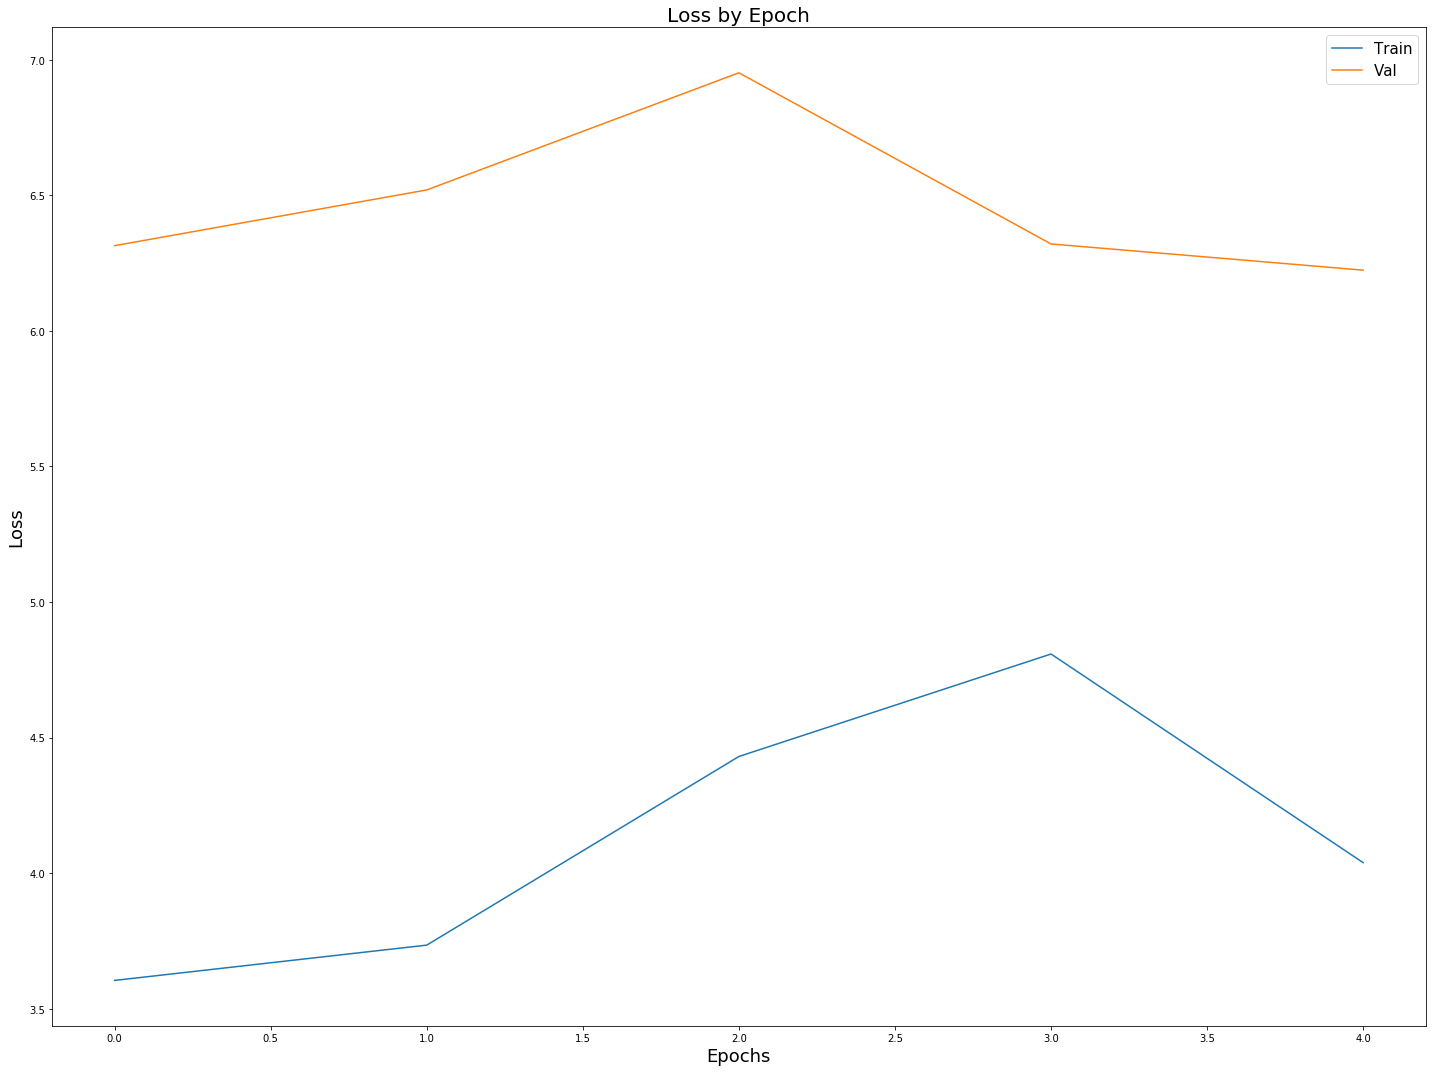

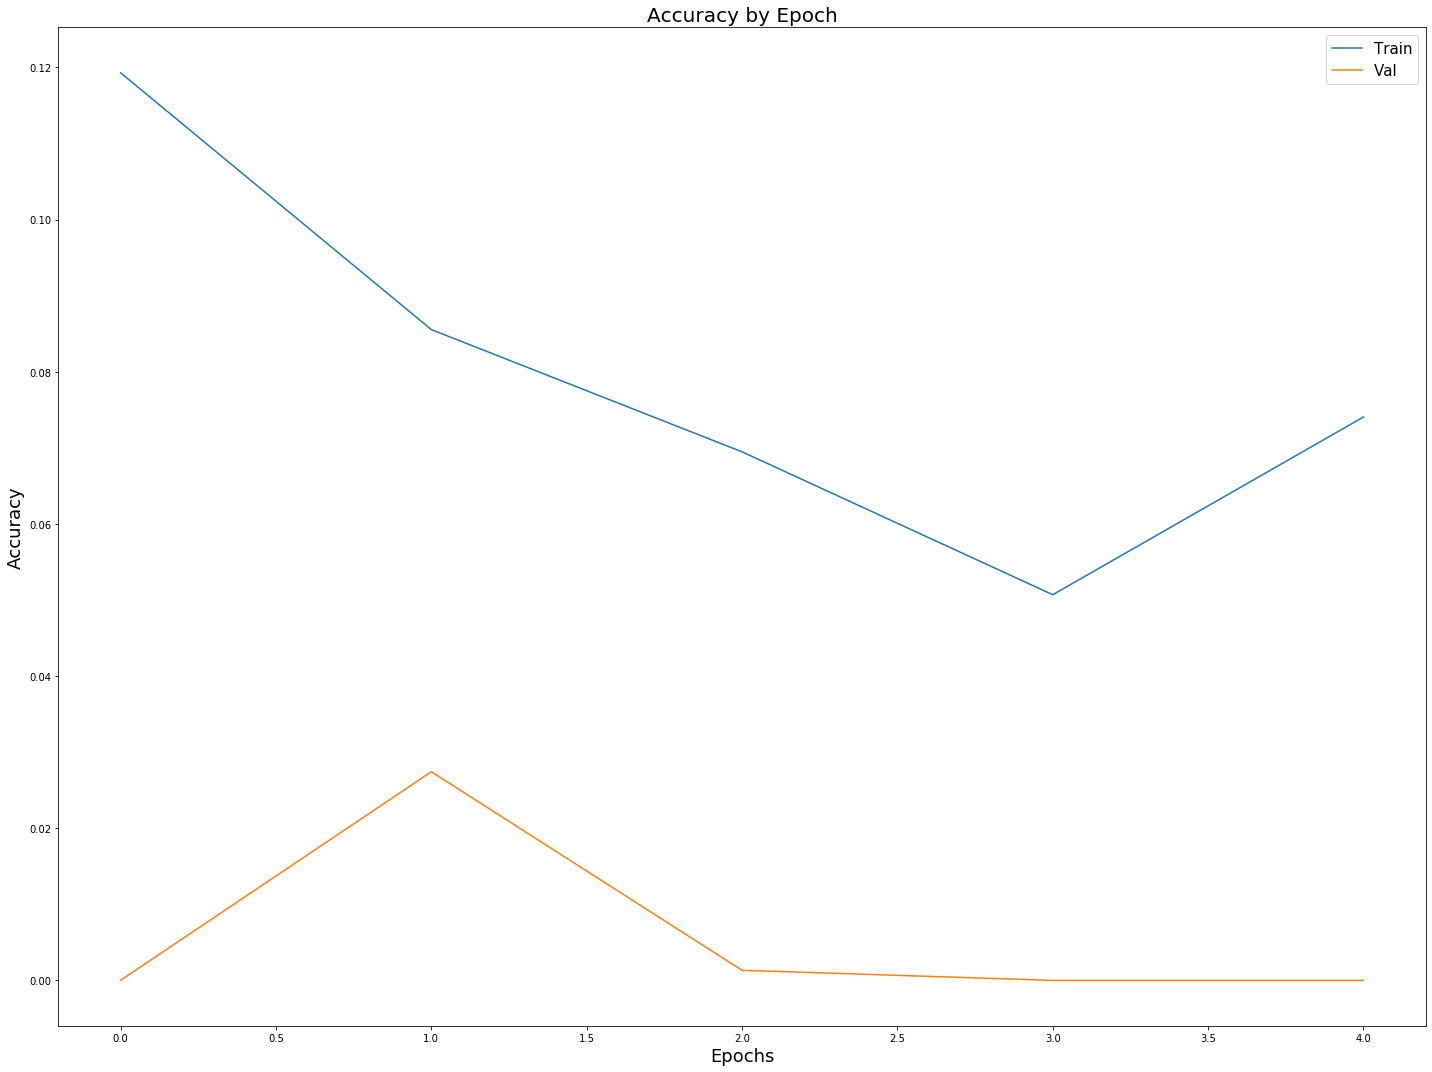

In [24]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
        train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
        train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
        # Save loss and accuracy from train and validation sets
        np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        # Save train sample stats
        np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
        np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
        np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
        
except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, len(train_metrics_tracker.get_metrics_by_name('loss')))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Loss by Epoch.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Accuracy by Epoch.png')
    plt.show()

### Load Train Sample Stats

In [25]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Plot Train Sample Stats

In [26]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

In [27]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

<Figure size 432x288 with 0 Axes>

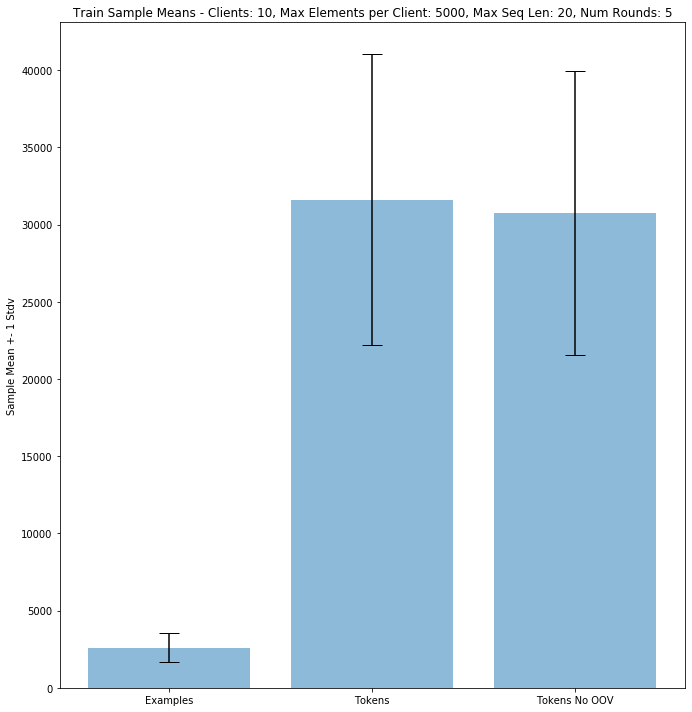

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

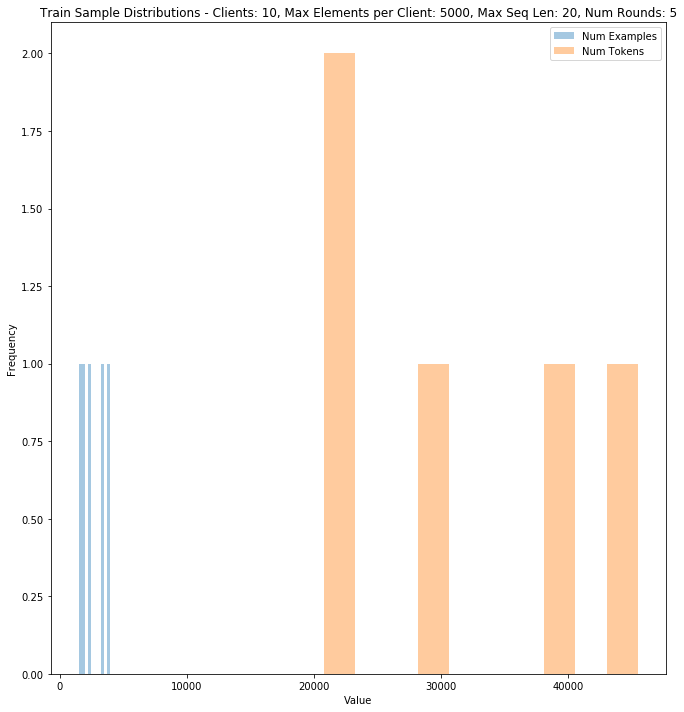

In [29]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

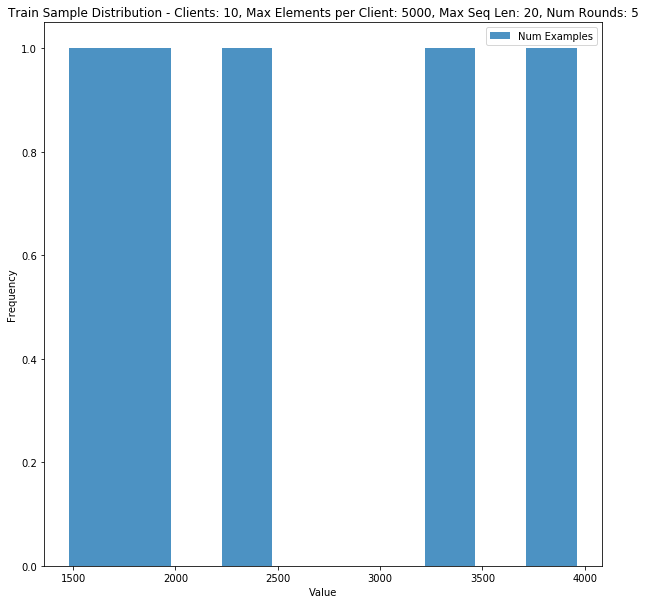

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

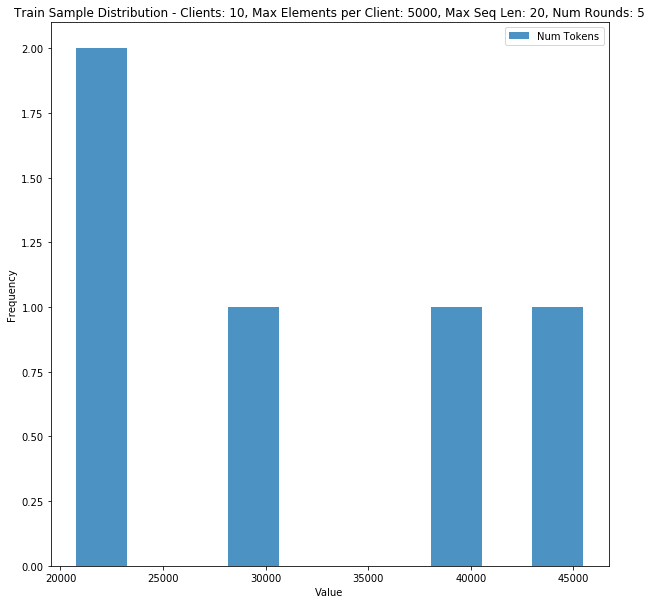

In [31]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

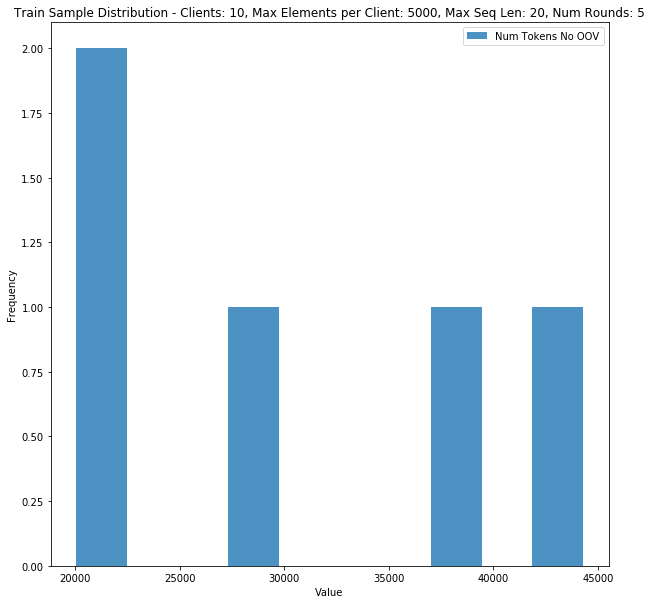

In [32]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

### Load Loss and Accuracy Arrays

In [33]:
train_loss = np.load(SAV + 'train_loss.npy')
train_accuracy = np.load(SAV + 'train_accuracy.npy')
val_loss = np.load(SAV + 'val_loss.npy')
val_accuracy = np.load(SAV + 'val_accuracy.npy')

### Validate Array Sizes

In [34]:
train_loss.shape

(5,)

In [35]:
train_accuracy.shape

(5,)

In [36]:
val_loss.shape

(5,)

In [37]:
val_accuracy.shape

(5,)